NRES Signal to  trend analysis
---

Plot normalized signal to noise as repoprted by NRES pipeline.

Input: a number of input files containing the signal to noise for starts:

   Format:
   STAR_NAME  Vmag  SN   Texp
       
Code will calculate the S/N normalized to a 60 sec exposure. However, this calculation assumes that 
exposurs remain shot noise dominated in this process, i.e., this calculation is somewhat off. 



In [16]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
import dateutil.parser
import glob
import tarfile
import tempfile
import os
import os.path
import PyPDF2
import re
import shutil

from astroquery.simbad import Simbad
plt.rcParams["figure.figsize"] = (10,6)
from matplotlib import style
plt.style.use('ggplot')

In [32]:

def readdata (fname):
    
    data = np.genfromtxt (fname, unpack=True, dtype=None, 
                          skip_footer=0, names=['star','vmag','sn','texp'])
    sn60 = data['sn'] * np.sqrt (60. / data['texp'])
    return data['star'], data['vmag'], sn60


def snmodel (s0=180000, ron=5):
    x = np.arange (2,13,0.5)
    s = 10 ** (-0.4 * x) * s0
    sn = s / np.sqrt (s + 3 * ron ** 2)
    return x, sn

    

def plotfile (fname, color, label, refflux, ron=5, badcutoff=25000):
    if (fname is not None):
        if os.path.isfile(fname) and (os.path.getsize(fname) > 10) :
            (star,v,sn) = readdata (fname)
            plt.semilogy (v,sn,'o', color=color, label=label)
        
    if refflux > 0:    
        (x,sn) = snmodel (refflux,ron)
        plt.semilogy (x,sn, color=color, label='model %s' % label)
    

Tired of opening all those pdf files and reading the S/N value from the pipeline? Are you tired of looking up the star's magnitude and adding it to a ascii table yourself? 
Yeah, me too. Now, just tell the procedure where you mount the nres data, which site, camera, and date you want to crawl, and it will do the rest for yu. Even the V magnitude will be grabbed from SIMBAD for you, if the name is resolvable.The output file name can then be read in for pretty plotting. 

In [18]:
objectTranslation = {
    'PSIPHE' : 'psi Phe',
    'MUCAS' : 'mu Cas',
    'KS18C14487' :'TYC 8856-529-1'
}

def crawldata (site, nres, date, mountpoint='/nfs/archive/engineering', outputname = None):
    """
        Crawl through a nres calibrated files directory and 
        (i) extract tar.gz, 
        (ii) read pdf summary plot file and aprse target name, exposure time, s/n
        (iii) query sinbad for v magnitude
        (iv) write output to text file
    """
    
    searchterm = '%s/%s/%s/%s/specproc/*.tar.gz' % (mountpoint, site, nres, date)
    
    starnames = []
    starmags = []
    starsns = []
    starexptimes = []
    
    tgzs = glob.glob (searchterm)
    for tgz in tgzs[0:]:
        with tarfile.open (tgz) as tf:
            bname = os.path.basename(tgz)[0:-7]
            tmpdir=tempfile.mkdtemp()
            tf.extractall (tmpdir)
            tf.close
        
        with open ('%s/%s/%s.pdf' % (tmpdir, bname, bname), 'rb') as pdffile:
            
            # Read the text content from pdf file, deeply burried in the tar ball.
            pdfreader = pdfreader = PyPDF2.PdfFileReader (pdffile)
            text = pdfreader.getPage(0).extractText()
            pdffile.close()
            shutil.rmtree(tmpdir)
            
            # parse the output with an easy to read regex.
            regex = '^([\w_\s\+-]+)\,\s.+expt\s?=\s?(\d+) s\,.+N=\s*(\d+\.\d+),'
            m = re.search (regex, text)
            if m is not None:
                
                starname = m.group(1)
                exptime  = m.group(2)
                sn       = m.group(3)
            else:
                print ("%s/%s pdf regex match failed" % (tmpdir, bname))
                print ("Input:\n%s\n%s" % (text, regex))
                continue
    
            # Query SIMBAD for the stellar magnitude
            mag = 99
            try:
                customSimbad = Simbad()
                customSimbad.add_votable_fields('flux(V)')
                
                
                searchname = starname if '_' not in starname else starname[0:starname.find('_')]
                if searchname in objectTranslation:
                    searchname = objectTranslation[searchname]
                print 'Searching for %s -> %s' % (starname, searchname)
                result = customSimbad.query_object(searchname)
                mag = result['FLUX_V'][0]  
                mag = float(mag) 
            except Exception as e:
                print ("Query failed", e)
                mag = 0
                
            # Log, and add everything to internal storge
            starname = starname.replace (' ','_')
            print bname, starname, mag, sn, exptime
            starnames.append (starname)
            starsns.append (sn)
            starexptimes.append (exptime)
            starmags.append (mag)      
            
    # And finally, write everything out to a text file for future use. 
    
    if outputname is None:
        outputname = "%s-%s.txt" % (nres,date)
    with open(outputname, "w+") as myfile:
        for ii in range (len (starnames)):
              myfile.write ('%s %s %s %s\n' %( starnames[ii], starmags[ii], starsns[ii], starexptimes[ii]) )  
        


In [36]:
#crawldata ('elp', 'nres02', '20171026')
for site,instrument in [('elp','nres02'),
                        ('lsc','nres01')]:

    for date in (['20171110','20171111','20171112','20171113','20171114','20171115',]):
        print site,instrument, date
        crawldata (site, instrument, date)

elp nres02 20171110
Searching for HR1084_TEMPL -> HR1084
elpnrs02-fl17-20171110-0018-e91 HR1084_TEMPL 3.73000001907 190.0 120
Searching for HR1544_FLUX -> HR1544
elpnrs02-fl17-20171110-0021-e91 HR1544_FLUX 4.34999990463 87.0 400
Searching for HR1544_FLUX -> HR1544
elpnrs02-fl17-20171110-0022-e91 HR1544_FLUX 4.34999990463 73.8 400
elp nres02 20171111
Searching for HR7596_FLUX -> HR7596
elpnrs02-fl17-20171111-0018-e91 HR7596_FLUX 5.63100004196 193.3 600
Searching for HR7596_FLUX -> HR7596
elpnrs02-fl17-20171111-0019-e91 HR7596_FLUX 5.63100004196 179.4 600
Searching for HD49933_TEMPL -> HD49933
elpnrs02-fl17-20171111-0022-e91 HD49933_TEMPL 5.78299999237 188.3 600
elp nres02 20171112
Searching for HR7950_TEMPL -> HR7950
elpnrs02-fl17-20171112-0016-e91 HR7950_TEMPL 3.76999998093 179.3 300
elp nres02 20171113
Searching for HD206860 -> HD206860
elpnrs02-fl17-20171113-0016-e91 HD206860 5.94999980927 19.8 900
Searching for HD206860 -> HD206860
elpnrs02-fl17-20171113-0017-e91 HD206860 5.94999980

Searching for GJ205 -> GJ205
lscnrs01-fl09-20171113-0047-e91 GJ205 7.96799993515 34.9 900
Searching for GJ33 -> GJ33
lscnrs01-fl09-20171113-0037-e91 GJ33 5.73999977112 114.1 900
Searching for GJ887 -> GJ887
lscnrs01-fl09-20171113-0035-e91 GJ887 7.34000015259 47.1 900
Searching for HD 38529 -> HD 38529
lscnrs01-fl09-20171113-0046-e91 HD_38529 5.92399978638 90.3 600
Searching for HD49933 -> HD49933
lscnrs01-fl09-20171113-0050-e91 HD49933 5.78299999237 117.9 900
Searching for GJ887 -> GJ887
lscnrs01-fl09-20171113-0040-e91 GJ887 7.34000015259 48.4 900
Searching for GJ205 -> GJ205
lscnrs01-fl09-20171113-0048-e91 GJ205 7.96799993515 35.4 900
Searching for GJ205 -> GJ205
lscnrs01-fl09-20171113-0049-e91 GJ205 7.96799993515 34.4 900
Searching for HD49933 -> HD49933
lscnrs01-fl09-20171113-0051-e91 HD49933 5.78299999237 119.5 900
lsc nres01 20171114
Searching for HD217107 -> HD217107
lscnrs01-fl09-20171114-0038-e91 HD217107 6.16300010681 64.5 720
Searching for GJ887 -> GJ887
lscnrs01-fl09-2017111

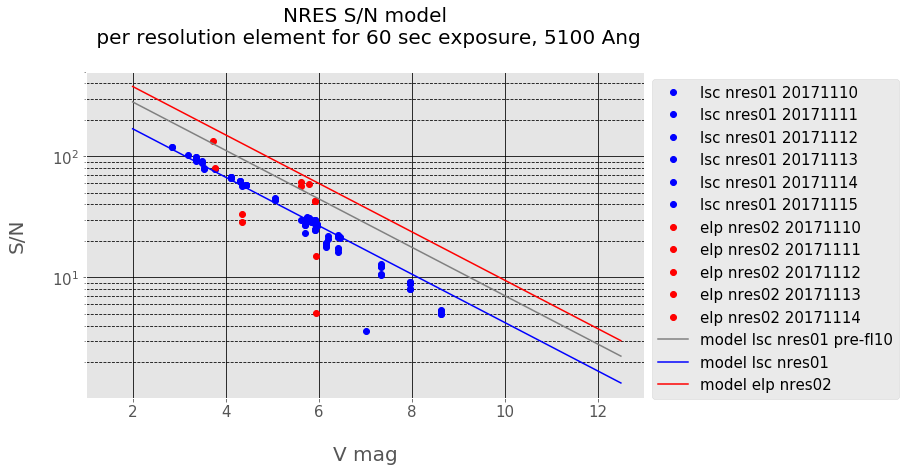

In [38]:

ron=5

fig, ax = plt.subplots(1)


for site,instrument in [
    ('lsc','nres01'),
    ('elp','nres02'),
    ]:

    for date in ('20171110','20171111','20171112','20171113','20171114','20171115',):
        pass
        plotfile ('%s-%s.txt' % (instrument, date), color='red' if site == 'elp' else 'blue', 
              label='%s %s %s' %(site,instrument,date),
              refflux=0)


plotfile (None , color='gray',  label ='lsc nres01 pre-fl10', refflux=500000, ron=0)
plotfile (None , color='blue',   label ='lsc nres01', refflux=180000, ron=0)
plotfile (None , color='red', label ='elp nres02', refflux=900000, ron=0)


lgd = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1,  fontsize=15)
plt.xlim([1,13])
plt.xlabel ( "\nV mag",  fontsize=20)
plt.ylabel ("S/N\n",  fontsize=20)
plt.title ("NRES S/N model\n per resolution element for 60 sec exposure, 5100 Ang\n",  fontsize=20)

ax.grid(b=True, which='major', color='k', linestyle='-')
ax.grid(b=True, which='minor', color='k', linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=10)
plt.subplots_adjust(top=0.88)
plt.savefig("nres01-02-model20171116.png", box_extra_artists=(lgd,), bbox_inches="tight");  